# Import Modules

In [1]:
import scanpy as sc
import squidpy as sq
import sys
sys.path.append(r"/home/yqzhou/JUPYTER/MyPackage/Pianno")
import pianno as po
import json
from os.path import join
import matplotlib.pyplot as plt
import matplotlib as mpl

# Data input

In [2]:
# Setting the data and configuration file storage path.
sample_name = "PDAC-A"
config_path = "/home/yqzhou/JUPYTER/Revision/Tutorials/" + sample_name
adata = sc.read(join(config_path, "pianno_adata.h5ad"))

# (Optional) Step1：Automatic hyper-parameter selection

In [3]:
# Specify a known marker gene for each pattern
# If there is a pattern that does not know its marker gene, it can be set to []
# Allow only one pattern's marker gene to be set to []
Patterndict = dict(Duct = ["CRISP3"],
                   Cancer = ["TM4SF1"],
                   Normal = ["CTRC"],
                   Stroma = [])

Configuration path of Pianno: /home/yqzhou/JUPYTER/Revision/Tutorials/PDAC-A
[2024-01-17 23:35:22] Creating experiment, Experiment ID: gp7ztd0u
[2024-01-17 23:35:22] Starting web server...
[2024-01-17 23:35:23] Timeout, retry...
[2024-01-17 23:35:24] Timeout, retry...
[2024-01-17 23:35:25] Timeout, retry...
[2024-01-17 23:35:26] Timeout, retry...
[2024-01-17 23:35:27] Setting up...
[2024-01-17 23:35:28] Web UI URLs: http://127.0.0.1:8080 http://10.10.10.18:8080 http://11.11.11.18:8080
[2024-01-17 23:45:39] Stopping experiment, please wait...
[2024-01-17 23:45:42] Experiment stopped


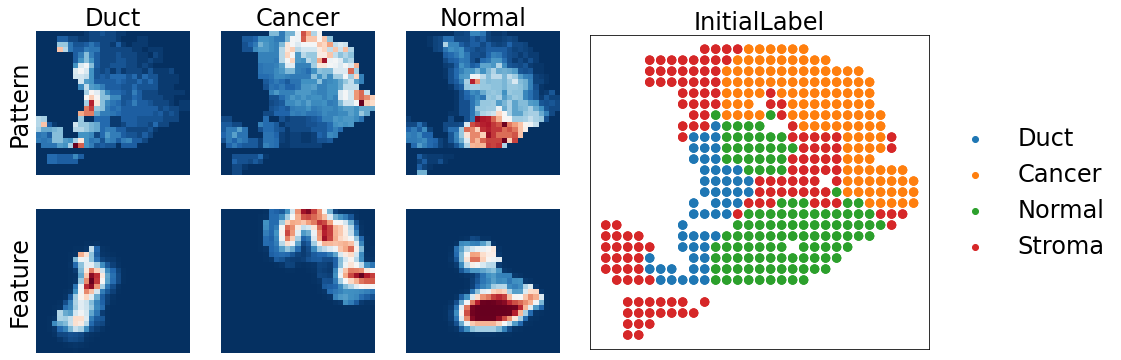

In [4]:
# If the connection fails, try a few more times.
# Open the Web UI URLs to visualize the hyperparameter tuning process.
# The default experiment lasts for a maximum of 10 minutes, 
# which can be modified according to the actual situation.
adata = po.AutoPatternRecognition(adata,
                                  Patterndict=Patterndict,
                                  config_path=config_path,
                                  param_tuning=True,
                                  max_experiment_duration='10m')

In [5]:
# Print the optimal parameters saved in the previous step.
with open(join(config_path, "best_params.json"),'r') as f:
    best_params_dict = json.load(f)
for key in best_params_dict:
    best_params = best_params_dict[key]  
best_params

{'n_class': 3,
 'dilation_radius': 4.0,
 'denoise_weight': 0.01,
 'unsharp_radius': 4.0,
 'unsharp_amount': 4.0,
 'gaussian_blur': 4.0}

# (Optional) Step2：Marker Selection

In [6]:
# Take the top 10 DEGs as candidate marker genes to make a proposed patterndict
Patterndict = po.ProposedPatterndict(adata, top_n=10)

Duct
['CTSS', 'EIF4G2', 'PLAT', 'MUC5B', 'PIGR', 'CRISP3', 'FOS', 'TGM2', 'ETS2', 'SNRPN']


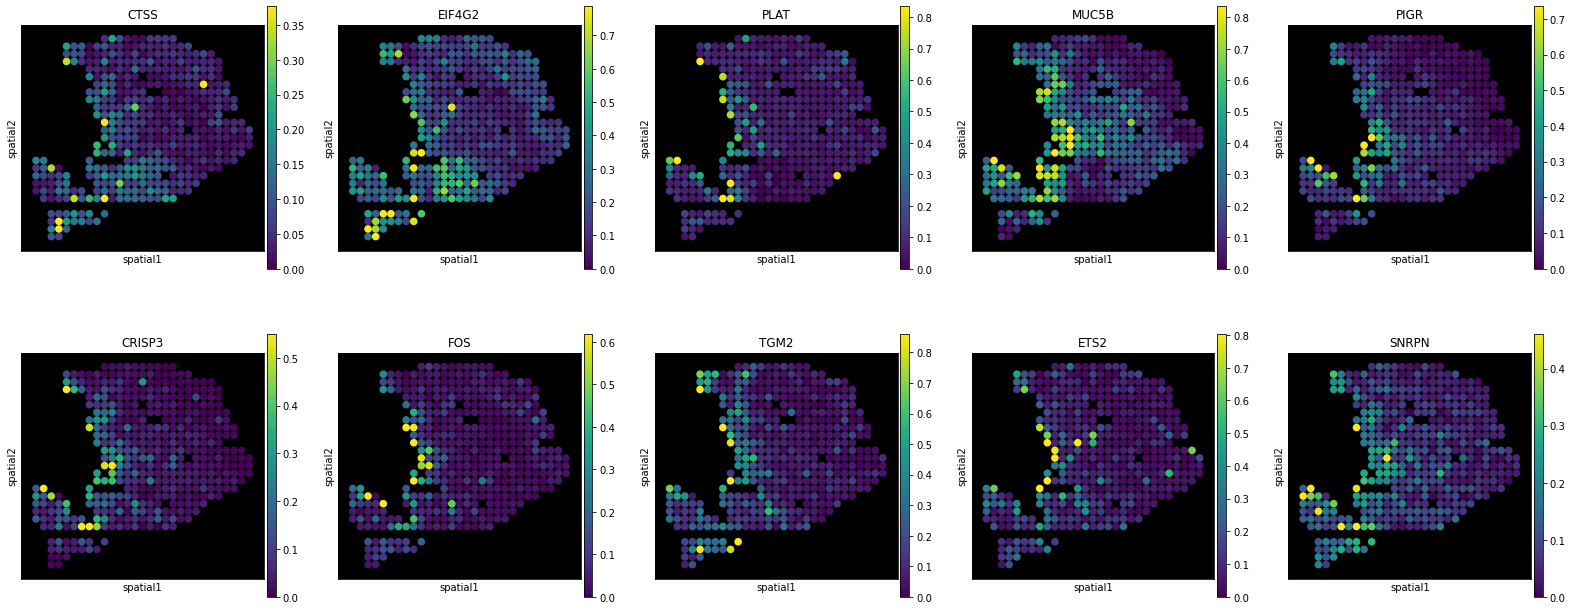

Cancer
['S100A6', 'GSTP1', 'KRT17', 'CYP2S1', 'MROH6', 'KRT18', 'ARL14', 'PLEC', 'TM4SF1', 'LAMC2']


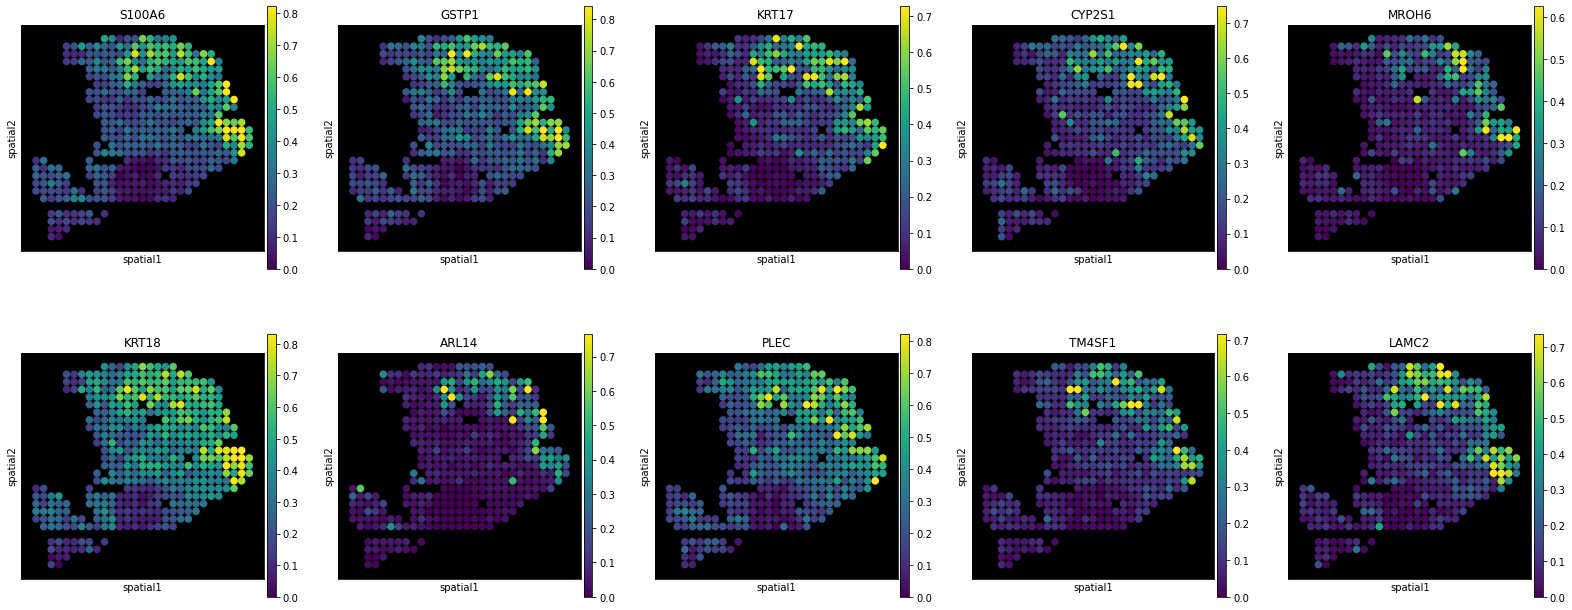

Normal
['CUZD1', 'PNLIP', 'CEL', 'CTRB1', 'GP2', 'PDIA2', 'CPA2', 'PNLIPRP1', 'PRSS1', 'PRSS3']


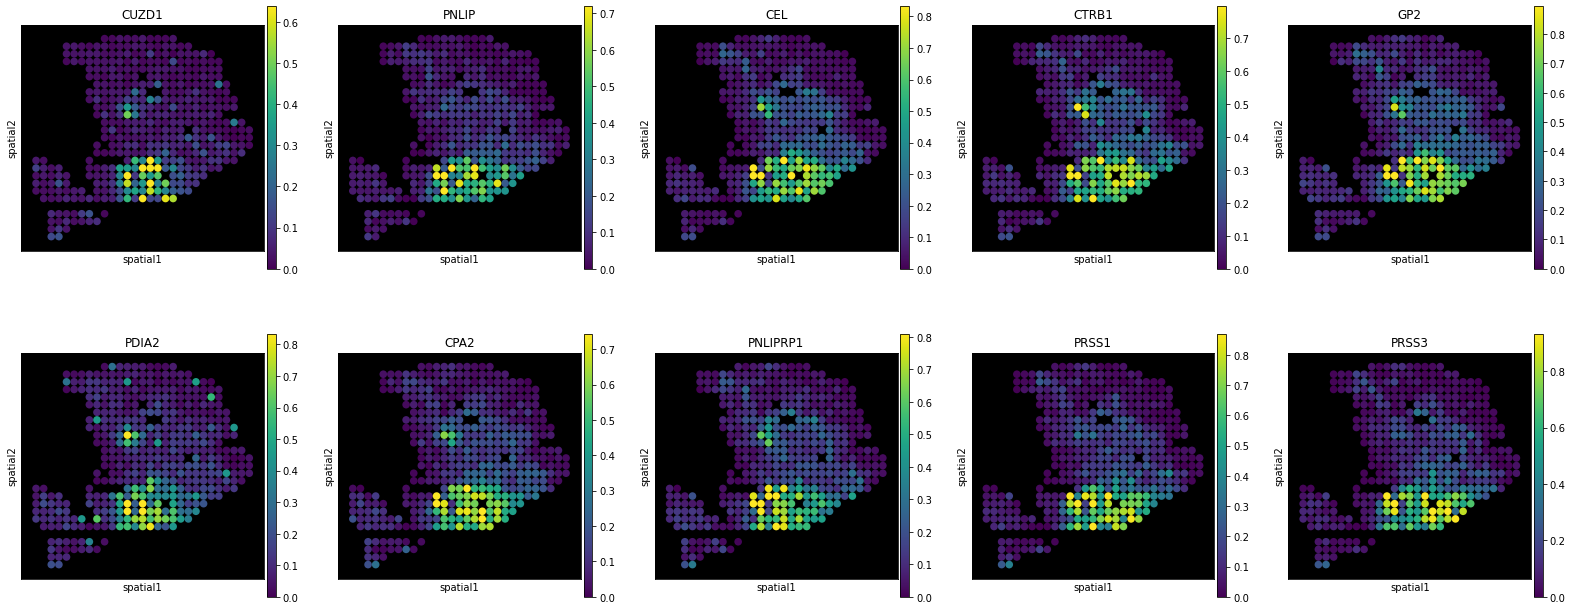

Stroma
['CCDC124', 'RAC1', 'KANK2', 'NT5DC2', 'LYPLAL1', 'DDX23', 'MTRNR2L10', 'AGR2', 'PPM1N', 'DHRS4']


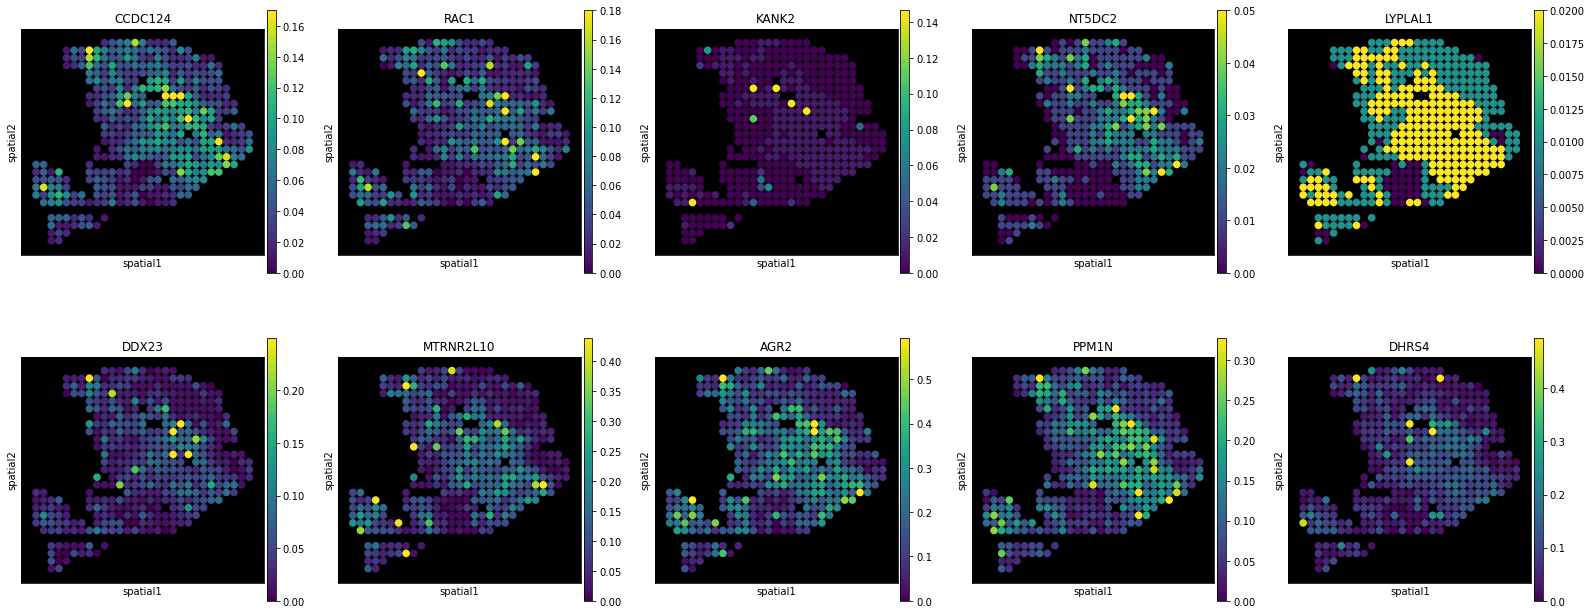

In [7]:
# Visualization of candidate marker genes
for k, v in Patterndict.items():
    print(k)
    print(v)
    with mpl.rc_context({'axes.facecolor':  'black',
                         'figure.figsize': [4.5, 5]}):
        sc.pl.spatial(adata, #cmap='magma',
                      layer='DenoisedX',
                      color=v,
                      ncols=5, size=1,
                      spot_size=1,
                      vmin=0, vmax='p99'
                     )

# Step3：Initial Pattern Recognition

In [8]:
# Construct the marker list by selecting 1-3 genes for each pattern 
# from the above candidate marker genes.
Patterndict = dict(Duct = ["CRISP3", 'FOS'],
                   Cancer = ["TM4SF1", 'KRT17', 'LAMC2'],
                   Normal = ['CTRC', 'GP2', 'PRSS1'],
                   Stroma = ['TCEANC2', 'GFPT2'])

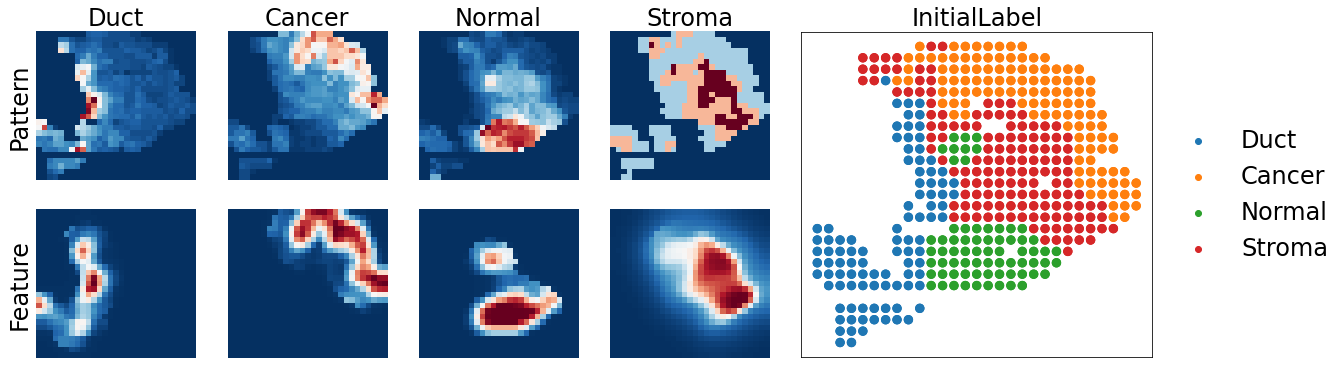

In [9]:
adata = po.AutoPatternRecognition(adata,
                                  Patterndict=Patterndict,
                                  config_path=config_path,
                                  param_tuning=False)

# Step4：Annotation Improvement

---Create Spatial Graph: Done!
---Compute Spatial Energy: Done!
---Find K-Nearest Neighbor in UMAP: Done!
---Compute KNN Energy: Done!
---Compute Global Energy: Done!


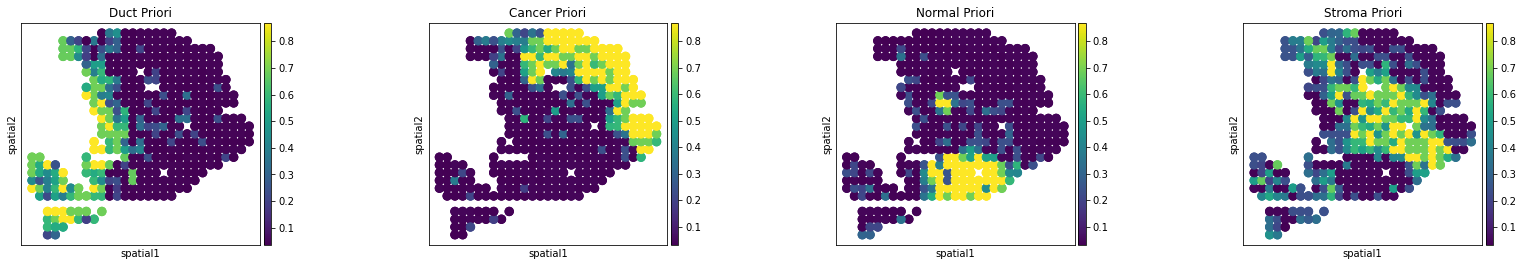

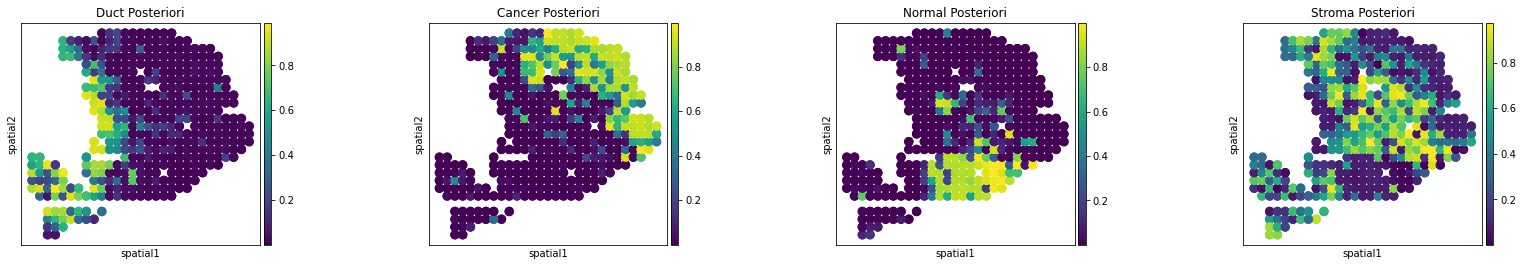

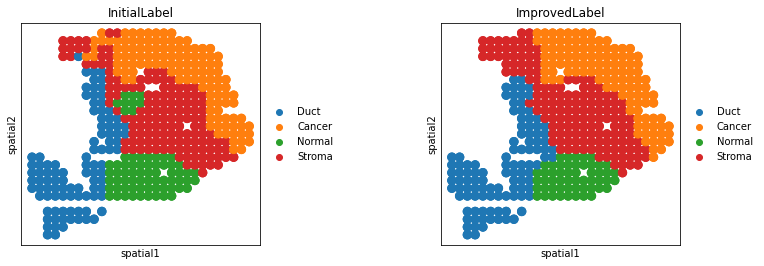

In [10]:
adata = po.AnnotationImprovement(adata)

---Create Spatial Graph: Done!
---Compute Spatial Energy: Done!
---Find K-Nearest Neighbor in UMAP: Done!
---Compute KNN Energy: Done!
---Compute Global Energy: Done!


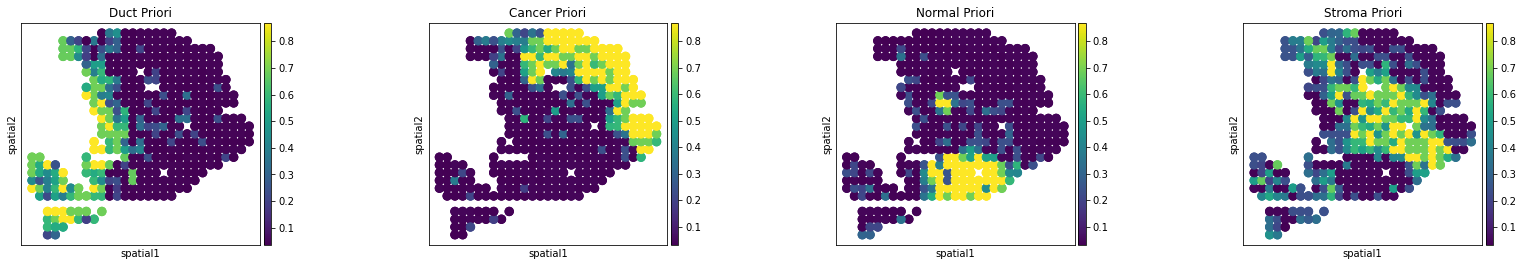

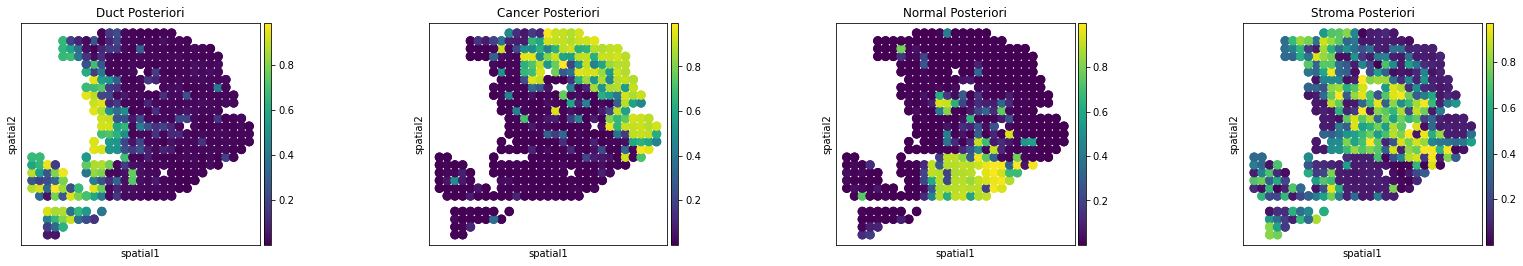

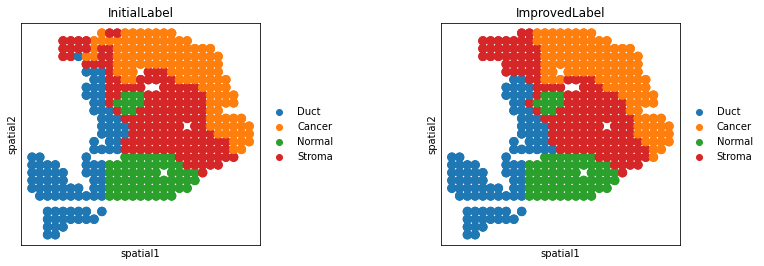

In [11]:
# When there are fewer spatial points and you want to preserve details, 
# set the threshold of small objects to 0.
# Set the initial label of certain patterns you want to keep in "keep".
adata = po.AnnotationImprovement(adata,
                                 small_objects=0,
                                 keep_region=['Normal'])